In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases_v4a import *
import cv2
import glob
import matplotlib.pyplot as plt
import os
from PIL import Image
import json
import copy

In [2]:
"""
@author Trong Nghia

"""
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def relu(Z):
    A = np.maximum(0,Z)
    return A

def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0 # nhung phần tử nhỏ hơn 0 trong Z sẽ được gán bằng 0 ở dZ, phần tử lớn hơn 0 ở Z thì giữ nguyên ở dZ
    return dZ

def sigmoid_backward(dA, Z):
    f = 1/(1+np.exp(-Z))
    dZ = dA * f * (1-f)
    return dZ

In [32]:
"""
@author Trong Nghia

Argument:
- arr_layer: ví dụ: [128*128*3,3,1]

returns:
- vector w    shape(arr_layer[i],arr_layer[i-1])
- integer b   shape(arr_layer[i], 1) có thể là shape(arr_layer[i], m)

"""
def init_parameter(arr_layer):
    L = len(arr_layer)
    parameters ={}
    print("number of layers: " + str(L))
    print("number of layers with parameters: " + str(L -1))
    for i in range(1, L):
        w = np.random.randn(arr_layer[i],arr_layer[i-1])*0.01
        b = np.zeros((arr_layer[i],1))
        parameters["W" + str(i)] = w
        parameters["b" + str(i)] = b
    return parameters

In [7]:
"""
@author Trong Nghia

Arguments:
- X dữ liệu train               shape(arr_layer[0],m)
- parameters: array chứa các tham số (W, b) của các lớp 
- activatie_param_setting: array chứa kiểu hàm kích hoạt của các lớp

returns:
- AL: giá trị mô hình dự đoán    shape(1,m)
- caches: array chứa tham số (A_prev, W, b, Z) của các lớp size sẽ là số lượng lớp có tham số(không bao gồm lớp input)

"""
def foward_propagation(X, parameters, activatie_param_setting):
    caches = []
    A_prev = X
    L = len(parameters) // 2 + 1
    for i in range(1,L):
        W = parameters["W" + str(i)]
        b = parameters["b" + str(i)]
        Z = np.dot(W, A_prev) + b
        if activatie_param_setting[i-1] == "relu":
            AL = relu(Z)
        elif activatie_param_setting[i-1] == "sigmoid":
            AL = sigmoid(Z)
        
        cache =  (A_prev, W, b, Z)
        A_prev = AL
        caches.append(cache)
        
    return AL, caches

In [8]:
"""
@author Trong Nghia

Arguments:
- AL giá trị mô hình dự đoán   shape(1,m)
- Y: nhãn dữ liệu train        shape(1,m)
- caches: array chứa tham số (A_prev, W, b, Z) của các lớp size sẽ là số lượng lớp có tham số(không bao gồm lớp input)
- activatie_param_setting: array chứa kiểu hàm kích hoạt của các lớp

returns:
- grads: array chứa đạo hàm của các tham số (dA_prev, dW, db, dZ) của các lớp size sẽ là số lượng lớp có tham số(không bao gồm lớp input)

"""
def back_propagation(AL, Y, caches, activatie_param_setting):
    m = Y.shape[1]
    dA = (AL-Y)/(AL*(1-AL))
    L = len(caches)
    Y = Y.reshape(AL.shape)
    grads = {}
    for i in reversed(range(L)):
        A_prev, W, b, Z = caches[i]
        if activatie_param_setting[i] == "sigmoid":
            dZ = sigmoid_backward(dA,Z)
            dA_prev = np.dot(W.T, dZ)
            dW = np.dot(dZ,A_prev.T)/m
            db = np.sum(dZ, axis=1, keepdims =True)/m
            grads["dA" + str(i)] = dA_prev
            grads["dW" + str(i+1)] = dW
            grads["db" + str(i+1)] = db
            grads["dZ" + str(i+1)] = dZ
        elif activatie_param_setting[i] == "relu":
            dZ = relu_backward(dA,Z)
            dA_prev = np.dot(W.T, dZ)
            dW = np.dot(dZ,A_prev.T)/m
            db = np.sum(dZ, axis=1, keepdims =True)/m
            grads["dA" + str(i)] = dA_prev
            grads["dW" + str(i+1)] = dW
            grads["db" + str(i+1)] = db
            grads["dZ" + str(i+1)] = dZ
        dA = dA_prev
    return grads

In [11]:
"""
@author Trong Nghia

Arguments:
- parameters: array chứa các tham số sau mỗi epoch(sau quá trình tính xuôi và tính ngược)
- grads: array chứa đạo hàm của các tham số (dA_prev, dW, db, dZ) của các lớp size sẽ là số lượng lớp có tham số(không bao gồm lớp input)
- learning_rate: là tốc độ học của mô hình

returns:
- parameters: array chứa các tham số sau khi được cập nhật

"""
def update_parameter(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for i in range(L):
        parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate*grads["dW" + str(i+1)]
        parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate*grads["db" + str(i+1)]
    return parameters

In [9]:
"""
@author Trong Nghia

Arguments:
- AL: là giá trị dự đoán của mô hình               shape(1, m)
- Y: là giá trị thực (nhãn) của các điểm dữ liệu   shape(1, m)

returns:
- cost: là giá trị loss

"""
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.sum((Y*np.log(AL)) + (1 - Y)*np.log(1-AL))/m
    cost = np.squeeze(cost)
    return cost

In [70]:
"""
@author Trong Nghia

Arguments:
- X: là dự liệu input          shape(arr_layer[0],m)
- Y: nhãn dữ liệu train        shape(1,m)
- parameters: array chứa các tham số khởi tạo của các lớp (W ,b)
- activatie_param_setting: array chứa kiểu hàm kích hoạt của các lớp
- epoch: số lần lặp
- learning_rate: tốc độ học

returns:
- costs: array chứa giá trị loss của mỗi 100 lần lặp
- arr_epoch: array chứa số thứ tự của lần lặp lưu giá trị loss
- model: dictionary chứa giá trị tham số (W, b) của mô hình tại mỗi 100 lần lặp(cứ mỗi 100 lần lặp lại lưu các giá trị mô hình lại)

"""
def fit(X, Y, parameters, activatie_param_setting, epoch, learning_rate):
    costs = []
    model = {}
    arr_epoch = np.arange(1,epoch+1,100)
    for i in range(epoch):
        AL, caches = foward_propagation(X, parameters, activatie_param_setting)
        cost = compute_cost(AL, Y)
        grads = back_propagation(AL, Y, caches, activatie_param_setting)
        parameters = update_parameter(parameters, grads, learning_rate)
        if i % 100 == 0:
            print("cost epoch "+str(i)+ ": " + str(cost))
            model[str(i)] = copy.deepcopy(parameters)
            costs.append(cost)
    return costs, arr_epoch, model

In [17]:
"""
@author Trong Nghia

Arguments:
- X: là dự liệu input          shape(arr_layer[0],m)
- parameters: array chứa các tham số khởi tạo của các lớp (W ,b)
- activatie_param_setting: array chứa kiểu hàm kích hoạt của các lớp

returns:
- label_predict: nhãn dự đoán của mô hình
- num_label_1: số lượng ảnh là nhãn 1
- num_label_0: số lượng ảnh là nhãn 0

"""
def predict(X, parameters, activatie_param_setting):
    AL, caches = foward_propagation(X, parameters, activatie_param_setting)
    label_predict = np.zeros((1,AL.shape[1]))
    num_label_1 = 0
    num_label_0 = 0
    for i in range(AL.shape[1]):
        if(AL[0][i] > 0.5):
            label_predict[0][i] = 1
            num_label_1 +=1
        elif(AL[0][i] == 0.5):
            label_predict[0][i] = 0.5
        else:
            label_predict[0][i] = 0
            num_label_0 += 1
    return label_predict, num_label_1, num_label_0

In [12]:
"""
@author Trong Nghia

"""
def load_config(path_file_config):
    with open(path_file_config) as file_object:
        config_data = json.load(file_object)
        return config_data

In [13]:
"""
@author Trong Nghia

"""
def load_label(path_foder_data, path_foder_label_json):
    data_path = os.path.join(path_foder_data,'*jpg')
    files = glob.glob(data_path)
    with open(path_foder_label_json) as file_object:
        label_all = json.load(file_object)
        return label_all

In [14]:
"""
@author Trong Nghia

"""
def load_data(path_dir_data, path_dir_data_label , image_widght, image_height, chanel):
    label_all = load_label(path_dir_data, path_dir_data_label)
    data_path = os.path.join(path_dir_data,'*jpg')
    files = glob.glob(data_path)
    number_items = len(files)
    data1 = []
    data = np.zeros((number_items,image_widght,image_height, chanel))
    data_label = np.zeros((1,number_items))
    for i in range(number_items):
        img = cv2.imread(files[i])
        data2 = files[i].split('\\')
        name_image = data2[len(data2)-1]
        data_label[0][i] = label_all["data"][name_image]["label"]
        data1.append(img)
    images = np.asarray(data1)
    for i in range(images.shape[0]):
        data[i]= images[i]/255#khi gan bien sang kieu mang numpy, cac phan tu se tu dong chuyen sang kieu float ma cac pixel anh o kieu float chi tu 0->1 nen phai chia cho 255 de dam bao cac pixel anh kieu float nam trong [0,1]
    return data, data_label

In [15]:
"""
@author Trong Nghia

"""
def standardized_image_test(path_dir_data, image_widght, image_height, chanel):
    data_path = os.path.join(path_dir_data,'*jpg')
    files = glob.glob(data_path)
    number_items = len(files)
    data1 = []
    data = np.zeros((number_items,image_widght,image_height, chanel))
    for i in range(number_items):
        img = cv2.imread(files[i])
        data2 = files[i].split('\\')
        data1.append(img)
    images = np.asarray(data1)
    for i in range(images.shape[0]):
        data[i]= images[i]/255#khi gan bien kieu numpy cac phan tu se tu dong chuyen sang kieu float ma cac pixel anh o kieu float chi tu 0->1 nen phai chia cho 255 de dam bao cac pixel anh kieu float nam trong [0,1]
    return data

In [121]:
"""
@author Trong Nghia

"""
#load file cấu hình
PATH_FILE_CONFIG = "C:\\Users\\Trong Nghia\\AppData\\Local\\Programs\\Python\\Python36\\Scripts\\Jupyter file code\\Neural network\\config.json"
CONFIG = load_config(PATH_FILE_CONFIG)
IMAGE_WIDGHT = CONFIG["config"]["IMAGE_WIDGHT"]
IMAGE_HEIGHT = CONFIG["config"]["IMAGE_HEIGHT"]
CHANEL = CONFIG["config"]["CHANEL"]
EPOCH = CONFIG["config"]["EPOCH"]
LEARNING_RATE = CONFIG["config"]["LEARNING_RATE"]
PATH_FODER_DATA = CONFIG["config"]["PATH_FODER_DATA"]
PATH_FILE_LABEL = CONFIG["config"]["PATH_FILE_LABEL"]
PATH_FODER_IMAGE_TEST = CONFIG["config"]["PATH_FODER_IMAGE_TEST"]

In [20]:
"""
@author Trong Nghia

"""
data_train, data_label = load_data(PATH_FODER_DATA, PATH_FILE_LABEL, IMAGE_WIDGHT, IMAGE_HEIGHT, CHANEL)
X = data_train.reshape(data_train.shape[0], -1).T #shape (a,b,c,d) => shape (b*c*d,a)

In [122]:
"""
@author Trong Nghia

"""
#load dữ liệu test shape(m,image_widght,image_height,chanel)
X_TEST = standardized_image_test(PATH_FODER_IMAGE_TEST,IMAGE_WIDGHT, IMAGE_HEIGHT, CHANEL)

In [123]:
"""
@author Trong Nghia

"""
#chuẩn hóa dữ liệu cho model predict shape(image_widght*image_height*chanel,m)
X_TEST_STANDARD = X_TEST.reshape(X_TEST.shape[0], -1).T #shape (a,b,c,d) => shape (b*c*d,a)

In [99]:
"""
@author Trong Nghia

"""
parameters = init_parameter([X.shape[0],3,1])
activatie_param_setting = ["relu", "sigmoid"]
AL, caches = foward_propagation(X, parameters, activatie_param_setting)
print("Length of caches list = " + str(len(caches)) + "lengt AL: " +str(AL.shape))

numer layer: 3
numer layer param: 2
Length of caches list = 2lengt AL: (1, 600)


In [100]:
"""
@author Trong Nghia

"""
costs, arr_epoch, model = fit(X, data_label, parameters, activatie_param_setting, 10000, 0.0075)

cost epoch 0: 0.6931033344392669
cost epoch 100: 0.6929530335053458
cost epoch 200: 0.6926258008504139
cost epoch 300: 0.6917693184755467
cost epoch 400: 0.689081224462
cost epoch 500: 0.6823422732113442
cost epoch 600: 0.6680225397404507
cost epoch 700: 0.6474355768760884
cost epoch 800: 0.6236892087627092
cost epoch 900: 0.5971826246349531
cost epoch 1000: 0.5763176958403936
cost epoch 1100: 0.5369164726460135
cost epoch 1200: 0.5130982308013959
cost epoch 1300: 0.47475464642613086
cost epoch 1400: 0.4813281430953153
cost epoch 1500: 0.4535128647401952
cost epoch 1600: 0.48789891176510547
cost epoch 1700: 0.3870431187941393
cost epoch 1800: 0.45445451845792056
cost epoch 1900: 0.5563090426004398
cost epoch 2000: 0.3215421528550888
cost epoch 2100: 0.3032668880764896
cost epoch 2200: 0.3338315391051563
cost epoch 2300: 0.32613481820381673
cost epoch 2400: 0.3207915117254248
cost epoch 2500: 0.2723740863916043
cost epoch 2600: 0.22866661706736713
cost epoch 2700: 0.212240132365459
cost

In [124]:
Y_PREDICT, num_label_1, num_label_0 = predict(X_TEST_STANDARD, model["9900"], activatie_param_setting)

In [125]:
"""
@author Trong Nghia

"""
print("nhãn của dữ đoán của tập test:\n" + str(Y_PREDICT) +"\n\n")
print("số ảnh dự đoán là nhãn 1(cat):" + str(num_label_1))
print("số ảnh dự đoán là nhãn 0(dog):" + str(num_label_0))

nhãn của dữ đoán của tập test:
[[1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
  0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
  0. 1.]]


số ảnh dự đoán là nhãn 1(cat):38
số ảnh dự đoán là nhãn 0(dog):12


nhãn dự đoán: 0.0


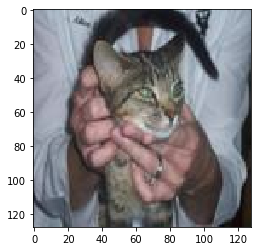

In [126]:
"""
@author Trong Nghia

"""
#hiển thị ảnh test
plt.imshow(X_TEST[9])
#hiển thị nhãn của ảnh test
print("nhãn dự đoán: "+ str(Y_PREDICT[0][9]))

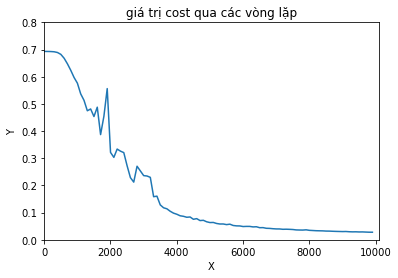

In [128]:
"""
@author Trong Nghia

"""
plt.plot(arr_epoch,costs, label='Python')
plt.title('giá trị cost qua các vòng lặp')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(0,0.8)
plt.xlim(0,10100)
plt.show()